### Importing necessary libraries

In [7]:
import torch
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Data Loading

In [8]:
df = pd.read_csv("./FuelConsumption.csv")

In [9]:
df.head(3)

,Year,MAKE,MODEL,VEHICLE CLASS,ENGINE SIZE,CYLINDERS,TRANSMISSION,FUEL,FUEL CONSUMPTION,COEMISSIONS
0,2000,ACURA,1.6EL,COMPACT,1.6,4,A4,X,10.5,216
1,2000,ACURA,1.6EL,COMPACT,1.6,4,M5,X,9.8,205
2,2000,ACURA,3.2TL,MID-SIZE,3.2,6,AS5,Z,13.7,265


Checking the range of target variable

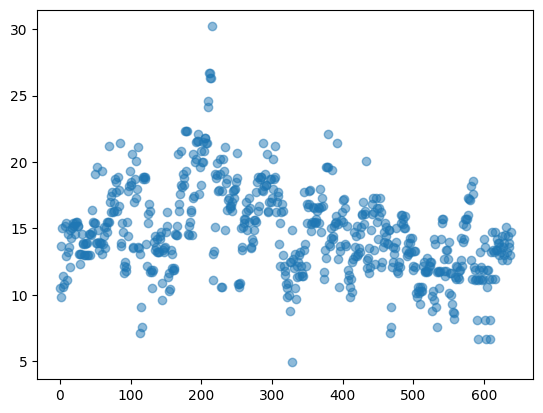

In [10]:
plt.scatter(df.index, df["FUEL CONSUMPTION"], alpha=0.5)
plt.show()

### Finding correlations and more knowledge about data

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 639 entries, 0 to 638
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Year              639 non-null    int64  
 1   MAKE              639 non-null    object 
 2   MODEL             639 non-null    object 
 3   VEHICLE CLASS     639 non-null    object 
 4   ENGINE SIZE       639 non-null    float64
 5   CYLINDERS         639 non-null    int64  
 6   TRANSMISSION      639 non-null    object 
 7   FUEL              639 non-null    object 
 8   FUEL CONSUMPTION  639 non-null    float64
 9   COEMISSIONS       639 non-null    int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 50.1+ KB


In [12]:
df.describe()

,Year,ENGINE SIZE,CYLINDERS,FUEL CONSUMPTION,COEMISSIONS
count,639.0,639.000000,639.000000,639.000000,639.000000
mean,2000.0,3.265728,5.805947,14.713615,296.809077
std,0.0,1.231012,1.625588,3.307044,65.504178
min,2000.0,1.000000,3.000000,4.900000,104.000000
25%,2000.0,2.200000,4.000000,12.500000,253.000000
50%,2000.0,3.000000,6.000000,14.400000,288.000000
75%,2000.0,4.300000,6.000000,16.600000,343.000000
max,2000.0,8.000000,12.000000,30.200000,582.000000


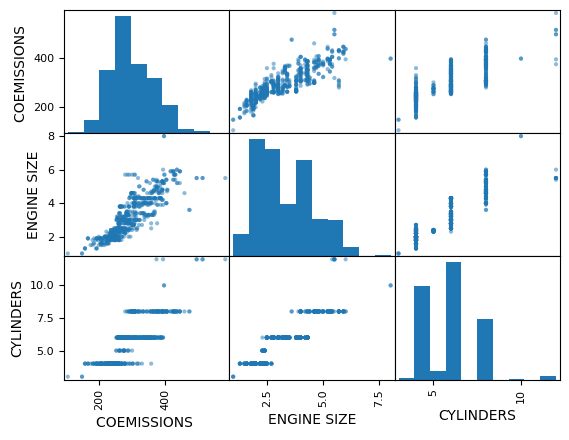

In [13]:
pd.plotting.scatter_matrix(df[['COEMISSIONS ', 'ENGINE SIZE', 'CYLINDERS']])
plt.show()

### Setting up features and labels

In [14]:
x = torch.tensor(df[['COEMISSIONS ', 'ENGINE SIZE', 'CYLINDERS']].to_numpy(), dtype=torch.float32)
y = torch.tensor(df["FUEL CONSUMPTION"], dtype=torch.float32)
print(x[0])
print(y[0])

tensor([216.0000,   1.6000,   4.0000])
tensor(10.5000)


### Reshaping

In [15]:
x.shape, y.shape

(torch.Size([639, 3]), torch.Size([639]))

In [16]:
y = y.reshape((len(y), 1))
y.shape

torch.Size([639, 1])

### Feature normalization


Here we are performing min-max scaling

In [17]:
def normalize(x):
    x_min = x.min(0, keepdim=True).values
    x_max = x.max(0, keepdim=True).values
    x_normalized = (x - x_min) / (x_max - x_min)
    return x_normalized

In [18]:
x = normalize(x)
x[:3]

tensor([[0.2343, 0.0857, 0.1111],
        [0.2113, 0.0857, 0.1111],
        [0.3368, 0.3143, 0.3333]])

### Train/Test Sets

In [19]:
def split_dataset(x, y, percentage_threshold):
    threshold = int(x.shape[0] * percentage_threshold)

    x_train, y_train, x_test, y_test = x[:threshold], y[:threshold], x[threshold:], y[threshold:]
    
    return x_train, y_train, x_test, y_test

In [20]:
x_train, y_train, x_test, y_test = split_dataset(x, y, 0.7)

print('x_train', x_train.shape)
print('y_train', y_train.shape)
print('x_test', x_test.shape)
print('y_test', y_test.shape)

x_train torch.Size([447, 3])
y_train torch.Size([447, 1])
x_test torch.Size([192, 3])
y_test torch.Size([192, 1])


### Creating a model

In [21]:
class LinearRegression(nn.Module):
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(3, 1)
        
    def forward(self, x):
        return self.linear(x)

In [22]:
model = LinearRegression()
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=0.01)
history = []

### Training Model

In [23]:
# Without regularization

# for epoch in range(100):
#     model.train()
#     optimizer.zero_grad()
#     outputs = model(x_train)
#     loss = criterion(outputs, y_train)
#     loss.backward()
#     optimizer.step()
    
#     history.append(loss.item())

# With l1 regularization

l1_lambda = 0.005
l2_lambda = 0.01

optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=l2_lambda)

for epoch in range(100):
    outputs = model(x_train)
    loss = criterion(outputs, y_train)
    
    l1_norm = sum(p.abs().sum() for p in model.parameters())
    
    total_loss = loss + l1_lambda * l1_norm
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    history.append(loss.item())
    

### Gain insights into loss function

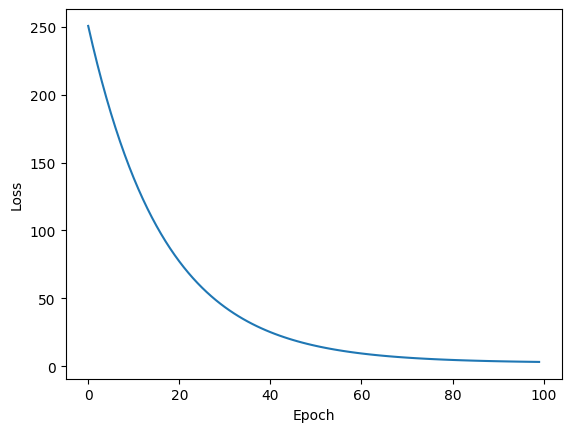

In [24]:
plt.plot(history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

### Model Prediction

In [25]:
train_predictions = model(x_train)
test_predictions = model(x_test)

In [26]:
train_predictions_numpy = train_predictions.detach().numpy()
test_predictions_numpy = test_predictions.detach().numpy()

### Plotting results

In [27]:
def create_plots(predictions, actual, predictions_color="magenta"):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    predictions_length = len(predictions)

    indices = list(range(predictions_length))

    ax1.scatter(indices, actual, alpha=0.5, label="Actual")
    ax1.scatter(indices, predictions, alpha=0.5, label="Predicted", color=predictions_color)
    ax1.set_xlabel('Index')
    ax1.set_ylabel('Fuel Consumption')
    ax1.set_title('Scatter Plot of Fuel Consumption')
    ax1.legend()

    ax2.scatter(indices, actual, label='Actual', alpha=0.5)
    ax2.plot(indices, predictions, label='Prediction Line', color=predictions_color)
    ax2.set_xlabel('Index')
    ax2.set_ylabel('Fuel Consumption')
    ax2.set_title('Fuel Consumption Prediction with Line')
    ax2.legend()

    plt.show() 

Training data

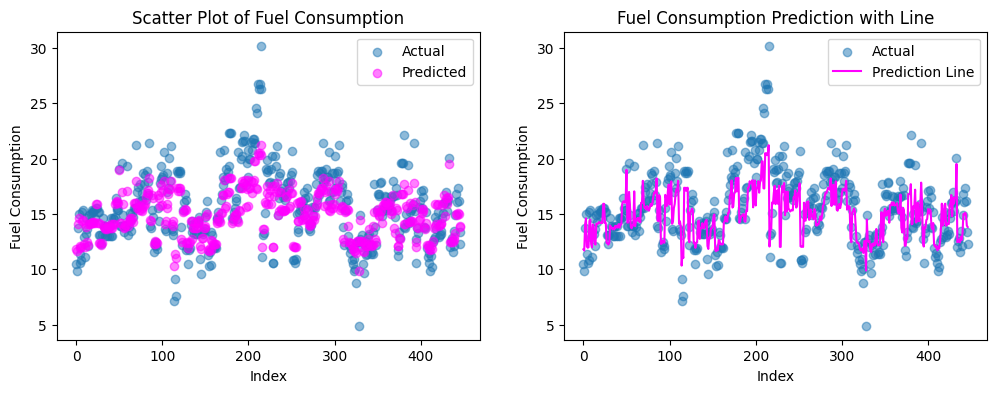

In [28]:
create_plots(train_predictions_numpy, df["FUEL CONSUMPTION"][:len(train_predictions_numpy)])

Test Data

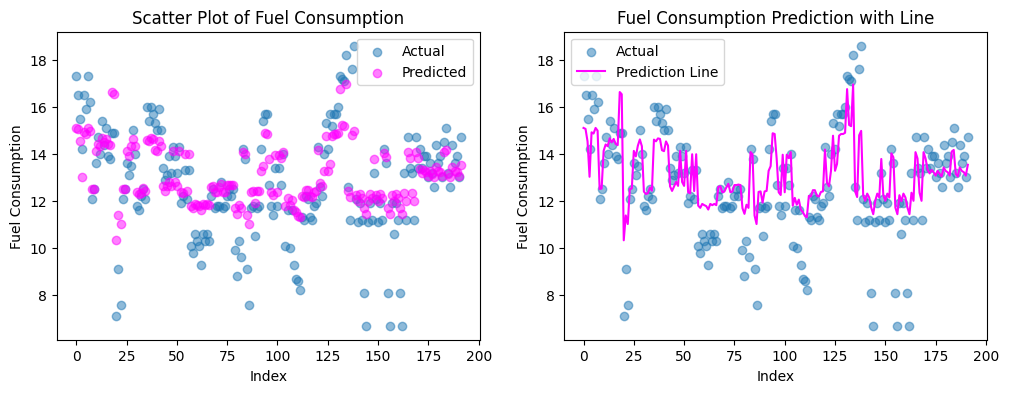

In [29]:
create_plots(test_predictions_numpy, df["FUEL CONSUMPTION"][len(train_predictions_numpy):])